In [109]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import glob
import os
from tqdm import tqdm
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
# import gresearch_crypto

In [85]:
# env = gresearch_crypto.make_env()

In [86]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# <span style='color: blue'> Read </span>

In [87]:
df_all = pd.read_csv('../Data/raw/train.csv')

In [88]:
df_test = pd.read_csv('../Data/raw/supplemental_train.csv').sample(20000, random_state=42)

# <span style='color: blue'> Preprocessing </span>

In [89]:
# not null
df_test = df_test[df_test['Target'].notnull()]
df_all = df_all[df_all['Target'].notnull()]
df_all = df_all[(df_all['VWAP'] != -np.inf) & (df_all['VWAP'] != np.inf)]
df_all = df_all[df_all['VWAP'].notnull()]

In [90]:
# get unique assets
unique_assets = df_all['Asset_ID'].unique()
unique_assets.sort()

### Sample

In [91]:
dfs_reduced = []
for i in tqdm(unique_assets):
    asset_type = df_all[df_all['Asset_ID'] == i].sort_values('timestamp')
    dfs_reduced.append(asset_type.sample(100000, random_state=42))

100%|██████████| 14/14 [00:09<00:00,  1.47it/s]


In [92]:
df_reduced = pd.concat(dfs_reduced)

### One-Hot Encode

In [93]:
encoder = OneHotEncoder(categories = 'auto')
np_train = np.array(df_reduced['Asset_ID']).reshape(-1,1)
np_test = np.array(df_test['Asset_ID']).reshape(-1,1)

encoder.fit(np_train)
asset_cols = list(encoder.categories_[0])

In [94]:
# transform training set
encoded_train = encoder.transform(np_train).toarray()
df_encoded_train = pd.DataFrame(encoded_train, columns=asset_cols)

# transform test set
encoded_test = encoder.transform(np_test).toarray()
df_encoded_test = pd.DataFrame(encoded_test, columns=asset_cols)

### Min-Max Scaler

In [95]:
feats = ['Open', 'Close', 'High', 'Low', 'Volume', 'VWAP']

In [96]:
scaler = MinMaxScaler()
scaler.fit(df_reduced[feats])

MinMaxScaler()

In [97]:
df_train_transformed = pd.DataFrame(scaler.transform(df_reduced[feats]), columns = feats)
df_test_transformed = pd.DataFrame(scaler.transform(df_test[feats]), columns = feats)

### Concat

In [98]:
df_train_pro = pd.concat([df_encoded_train.reset_index(drop=True), 
                          df_train_transformed.reset_index(drop=True), 
                          df_reduced['Target'].reset_index(drop=True)], axis=1)

df_test_pro = pd.concat([df_encoded_test.reset_index(drop=True), 
                         df_test_transformed.reset_index(drop=True),
                         df_test['Target'].reset_index(drop=True)], axis=1)

# <span style='color: blue'> Split X and Y </span>

In [99]:
x_train = df_train_pro[asset_cols + feats]
y_train = df_train_pro['Target']

x_test = df_test_pro[asset_cols + feats]
y_test = df_test_pro['Target']

# <span style='color: blue'> Base Model </span>

In [79]:
xgb_reg = xgb.XGBRegressor(objective= "reg:squarederror")

In [80]:
xgb_reg.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
pred = xgb_reg.predict(x_test)

In [82]:
corr, _ = pearsonr(pred, y_test)
print('Correlation Score:', corr)

rmse = mean_squared_error(pred, y_test, squared=False)
print('RMSE:', rmse)

Correlation Score: 0.021824504058339522
RMSE: 0.004426630693329437


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

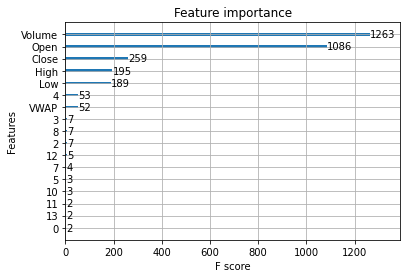

In [102]:
plot_importance(xgb_reg)

# <span style='color: blue'> Hyparameter Tuning </span>

In [ ]:
parameters = {
    "learning_rate": [0.01, 0.1, 0.2, 0.5] ,
    "max_depth": [3, 4, 5, 6, 8, 12, 15, 18],
    "min_child_weight": [1, 3, 5, 7],
    "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7, 1],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0]
}

In [ ]:
searchcv = RandomizedSearchCV(estimator=xgb_reg, param_distributions=parameters, scoring='neg_mean_squared_error',
                    cv=3, n_jobs=-1)

In [331]:
searchcv.fit(x_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=4,
                                          num_par...
                                          reg_alpha=0, reg_lambda=1,
                                          scale_pos_weight=1, subsample=1,
   

In [332]:
pred = searchcv.predict(x_test)

In [333]:
corr, _ = pearsonr(pred, y_test)
print('Correlation Score:', corr)

rmse = mean_squared_error(pred, y_test, squared=False)
print('RMSE:', rmse)

Correlation Score: 0.00982787014886271
RMSE: 0.004429274965292405


# <span style='color: blue'> Linear Regression </span>

In [103]:
# absolute poop model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
pred = lr_model.predict(x_test)

corr, _ = pearsonr(pred, y_test)
print('Correlation Score:', corr)

rmse = mean_squared_error(pred, y_test, squared=False)
print('RMSE:', rmse)

Correlation Score: 0.0075802195622147826
RMSE: 0.004426595713028357


# <span style='color: blue'> Submit </span>

In [19]:
# iter_test = env.iter_test()

In [20]:
# for (test_df, sample_prediction_df) in iter_test:
#     sample_prediction_df['Target'] = xgb_reg.predict(test_df[['Asset_ID', 'Open', 'Close', 'High', 
#                                                               'Low', 'Volume', 'VWAP']])
#     env.predict(sample_prediction_df)